# Название проекта: Компьютерные игры

**Цель проекта: Выявить закономерности, определяющие успешность игры**

**Описание проекта:**

Шаг 1. Загрузка данных, изучение общей информации.


Шаг 2. Предобработка данных.

* Преобразованы названия столбцов (приведены к нижнему регистру);
* Преобразованы данные в нужные типы:
  * year_of_release - int (тк только один год, при использовании типа datetime получается громоздкая конструкция с лишними данными);
  * user_score - float (есть дробные значения);
  * rating - category (занимает меньше памяти);
* Проверено налчие дубликатов (таких нет);
* Обработаны пропуски:
  * year_of_release - если в названии встречается год выпуска, замена произведена на год выпуска. Остальные данные заменены на нули в качестве индикатора.
  * critic_score, user_score, rating, genre, name  - нет возможности заполнить пропуски. Пропуски заменены на индикаторные значения:
    * critic_score = -1;
    * user_score = -2, значение tbd (рейтинг не определен в силу недостаточного количества отзывов) заменено на -1;
    * rating, genre, name = "Not Defined"
* В колонке rating K-A (старое обозначение Е) заменено на Е;
* Рассчитаны суммарные продажи во всех регионах, данные добавлены в отдельный столбец.

Шаг 3. Исследовательский анализ данных.

На данном этапе исследовано:
* Количество игр по годам. Определено, что значимыми показатели становятся не ранее чем с 1994 г.;
* Продажи игр по годам;
* Продажи по платформам:
   * Определены платформы с наибольшими суммарными продажами;
   * Построено распределение по годам;
   * Определен средний срок жизни платформы;

* Выбран актуальный период;
* Выбраны потенциально прибыльные платформы;
* Построен график «ящик с усами» по глобальным продажам игр в разбивке по платформам;
* Рассмотрено влияние на продажи внутри одной популярной платформы отзывов пользователей и критиков;
  * Построена диаграмма рассеяния и рассчитана корреляцию между отзывами и продажами;
  * Построена диаграмма рассеяния по выбранным платформам в целом;
* Изучено общее распределение игр по жанрам:
  * Определены самых популярные жанры;
  * Определены жанры с высокими и низкими продажами.

Шаг 4. Портрет пользователя каждого региона.

Для пользователя каждого региона (NA, EU, JP) определены:
 * Самые популярные платформы (топ-5);
 * Самые популярные жанры (топ-5);
 * Влияние рейтинга ESRB на продажи в отдельном регионе.

Шаг 5. Проверка гипотез.

Определен метод проверки гипотез для двух независимых выборок.
Проверены гипотезы:
* Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
* Средние пользовательские рейтинги жанров Action и Sports разные.

Общий вывод.

## Шаг. Загрузка данных, изучение общей информации.

Сделаем несколько предварительных шагов.

In [1]:
# Импортируем все необходимые библиотеки и методы

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy
import datetime  


from math import sqrt
from math import factorial
from scipy import stats as st
from scipy.stats import binom, norm
from datetime import datetime

In [2]:
# Зададим отображение всех колонок

pd.set_option("display.max.columns", None)

In [3]:
# Зададим отображение 2-х десятичных знаков

pd.options.display.float_format = '{:.2f}'.format

In [4]:
# Загрузим базу данных

games = pd.read_csv(# путь к файлу)

In [5]:
# Выведем первые 5 строк

games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.00,Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,1985.00,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.00,Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,2009.00,Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.00,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Данные считались корректно. В таблице есть пропуски. Вернемся кэтому в следующих шагах.

In [6]:
# Выведем общую информацию

games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Есть пропуски. Типы данных стоит поменять.

In [7]:
# Сохарним размер исходной таблицы, чтобы потом проверять, не потеряли ли мы слишком много данных.

len_original_games = games.shape[0]

In [8]:
# Выведем количество пропусков

games.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

Есть немного пропусков в колонке Год релиза, и значительное количество прпоусков в колонках Оценка критиков, Оценка пользователей и Рейтинг. И 2 пропуска в колонке Жанр. Посмотрим в дальнейшем, будет ли это критичным.

Для общего представления о данных, построим гистограмму распределения. Подробнее к этой информации мы вернемся в следующих пунктах.

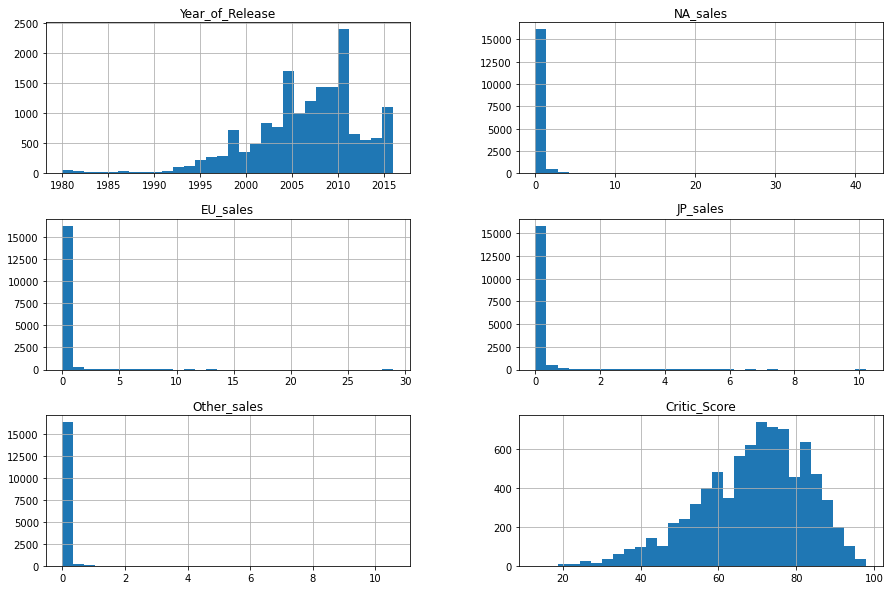

In [9]:
# Построим гисторгамму распределений

games.hist(figsize=(15,10), bins=30);

## Шаг. Предобработка данных.

### Регистр столбцов, тип данных.

In [10]:
# Приведем названия столбцов к нижнему регистру

games.columns = games.columns.str.lower()

In [11]:
# Проверим, что получилось

games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.00,Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,1985.00,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.00,Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,2009.00,Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.00,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Колонка year_of_release по смыслу должна бы иметь тип datetime. Но в этом случае добавляется дата начала года (01-01-... год) и значения получаются громоздкими. Мне кажется, более уместным заменить тип на целочисленные значения.

In [12]:
games['year_of_release'] = games['year_of_release'].astype('int', errors='ignore')

In [13]:
# Преобразуем колонку user_score в числовой формат

games['user_score'] = games['user_score'].astype('float', errors='ignore')

In [14]:
# Можно еще rating перевести в category, чтобы меньше места занимало

#games['rating'] = games['rating'].astype('category', errors='ignore')

In [15]:
# Проверим, что получилось

games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.00,Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,1985.00,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.00,Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,2009.00,Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.00,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [16]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Дубликаты и пропуски данных.

In [17]:
# Проверим наличие полных дубликатов

games.duplicated().sum()

0

Явных дубликатов в таблице нет. Проверим дубликаты по группе столбцов.

In [18]:
games[['name', 'platform', 'year_of_release']].duplicated().sum()

2

In [19]:
games[games.duplicated(['name', 'platform', 'year_of_release'])]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
14244,NaN,GEN,1993.00,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN
16230,Madden NFL 13,PS3,2012.00,Sports,0.00,0.01,0.00,0.00,83.00,5.5,E


In [20]:
# Удалим эти дубликаты, оставив первую повторяющуюся строку.

games.drop_duplicates(subset=['name', 'platform', 'year_of_release'], keep='first', inplace=True)

In [21]:
# Проверим, что удалились только 2 строки

games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16712 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16712 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8136 non-null   float64
 9   user_score       10013 non-null  object 
 10  rating           9948 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


Перейдем к пропускам.

In [22]:
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (15,3), legend = False, fontsize = 12)
            .set_title('Доля пропущенных данных' + "\n", fontsize = 14, color = 'Black')    
        );    
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

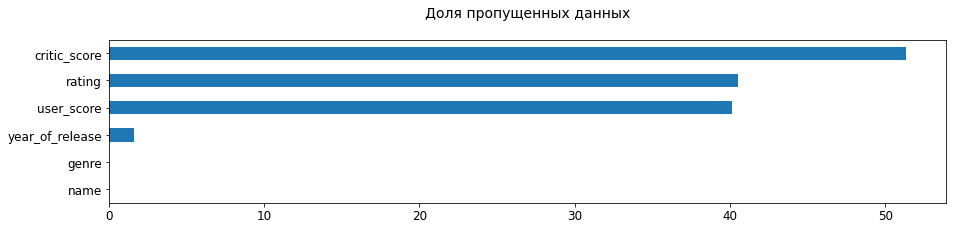

In [23]:
pass_value_barh(games)

Рассмотрим по порядку колонки: year_of_release, critic_score, user_score, rating.

In [24]:
# Рассмотрим year_of_release

games[games['year_of_release'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.00,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.00,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.00,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.00,tbd,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.00,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.00,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [25]:
round(games['year_of_release'].isna().sum() / games.shape[0]*100, 2)

1.61

1.6%, полагаю, не сильно повлияют на результаты. Тем не менее, посмотрим, можно ли определить год по имеющимся данным.

In [26]:
# Какие бывают названия игр  в строках с пропущеным year_of_release

games[games['year_of_release'].isna()]['name'].to_frame().head(55)

,name
183,Madden NFL 2004
377,FIFA Soccer 2004
456,LEGO Batman: The Videogame
475,wwe Smackdown vs. Raw 2006
609,Space Invaders
627,Rock Band
657,Frogger's Adventures: Temple of the Frog
678,LEGO Indiana Jones: The Original Adventures
719,Call of Duty 3
805,Rock Band


В некоторых играх встречается год. И, если смотреть по аналогичным строкам, это год выпуска игры +1. 
Часть пропусков можно заменить на это значение.

Поскольку год выпуска не может быть нулевым, а нам удобнее работать с числами, заменим пропуски на ноль в этой колонке.

In [27]:
games['year_of_release'] = games['year_of_release'].fillna(0)

In [28]:
games['year_of_release'] = games['year_of_release'].astype('int')

In [29]:
# Создадим словарь с названиями игр и годом выпуска (из названия)

years_add={}
for row in games.itertuples():
    #index = row[0]
    name = str(row[1])
    year = name[-4:]
    release = str(row[3])
    if year.isnumeric() and release == '0':
        years_add[name] = int(year)-1
years_add

{'Madden NFL 2004': 2003,
 'FIFA Soccer 2004': 2003,
 'wwe Smackdown vs. Raw 2006': 2005,
 'NASCAR Thunder 2003': 2002,
 'Madden NFL 2002': 2001,
 'NFL GameDay 2003': 2002,
 'NBA Live 2003': 2002,
 'All-Star Baseball 2005': 2004,
 'Tour de France 2011': 2010,
 'Sega Rally 2006': 2005,
 'PDC World Championship Darts 2008': 2007,
 'Football Manager 2007': 2006}

In [30]:
# Проверим, сколько пропусков будет заполнено...

games.loc[(games['name'].isin(years_add))&(games['year_of_release'] == 0)]['name'].count()

15

In [31]:
# ...Да и заменим их

for item in games.query('year_of_release == 0 and name in @years_add')['name'].unique():
    year = years_add.get(item)
    games.loc[(games['name'] == item)&(games['year_of_release'] == 0), 'year_of_release'] = int(year)

In [32]:
# Проверим количество пропусков сейчас

games[games['year_of_release'] == 0]['name'].count()

254

In [33]:
games.query('name  == "Madden NFL 2004"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,2003,Sports,4.26,0.26,0.01,0.71,94.00,8.5,E
1881,Madden NFL 2004,XB,2003,Sports,1.02,0.02,0.00,0.05,92.00,8.3,E
3889,Madden NFL 2004,GC,2003,Sports,0.40,0.10,0.00,0.01,94.00,7.7,E
5708,Madden NFL 2004,GBA,2003,Sports,0.22,0.08,0.00,0.01,70.00,6.6,E


In [34]:
games['year_of_release'].sort_values().unique()

array([   0, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016])

В принципе, если покопаться в интернете, можно попробовать найти годы релиза игр по названиям. Но количетсво пропусков не настолько велико (1,5% данных), чтобы тратить на это время. Оставим пока пропуски.

In [35]:
# Удалим данные без года релиза

games = games.query('year_of_release != 0')

In [36]:
games

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Удалилось 254 строки, все верно.

Рассмотрим теперь пропуски в оставшихся колонках.

In [37]:
# Какие бывают названия игр  в строках с пропущеным critic_score

games[games['critic_score'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN


In [38]:
# Какие бывают названия игр  в строках с пропущеным user_score

games[games['user_score'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN


In [39]:
# Какие бывают названия игр  в строках с пропущеным rating

games[games['rating'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN


In [40]:
# Уникальные значения в critic_score

games['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

In [41]:
# В каких годах у нас есть пропуски в critic_score и сколько их

games[games['critic_score'].isna()].pivot_table(index='year_of_release', values='name', aggfunc='count').T

year_of_release,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
name,9,46,36,17,14,13,21,16,14,17,16,41,42,60,120,219,255,272,351,299,207,156,202,190,201,286,387,506,712,775,755,636,332,271,320,381,270


In [42]:
# А сколько было самих игр в эти годы

games['year_of_release'].value_counts().sort_values().to_frame().T

,1980,1984,1985,1988,1987,1990,1989,1983,1986,1982,1991,1992,1981,1993,1994,1995,1996,1997,1999,2000,1998,2001,2016,2013,2014,2015,2012,2004,2003,2002,2005,2006,2011,2007,2010,2009,2008
year_of_release,9,14,14,15,16,16,17,17,21,36,41,43,46,61,121,219,263,289,338,350,379,483,502,544,581,606,652,764,777,833,941,1007,1136,1199,1256,1426,1427


In [43]:
# Посмотрим по каким играм до 1996 года есть отзывы критиков

games.query('year_of_release <= 1996 and year_of_release != 0 and critic_score >=0').sort_values(by='year_of_release')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
14470,Alter Ego,PC,1985,Simulation,0.00,0.03,0.00,0.01,59.00,5.8,T
14621,SimCity,PC,1988,Simulation,0.00,0.02,0.00,0.01,64.00,2.2,E10+
14610,Doom,PC,1992,Shooter,0.02,0.00,0.00,0.00,85.00,8.2,M
1567,Battle Arena Toshinden,PS,1994,Fighting,0.39,0.26,0.53,0.08,69.00,6.3,T
153,Tekken 2,PS,1996,Fighting,2.26,1.89,1.36,0.23,89.00,8.9,T
203,Resident Evil,PS,1996,Action,2.05,1.16,1.11,0.73,91.00,9,M
229,Tomb Raider,PS,1996,Action,2.29,1.97,0.13,0.24,91.00,8.6,T
903,PaRappa The Rapper,PS,1996,Misc,0.26,0.16,1.46,0.03,92.00,7.4,K-A
1160,Diablo,PC,1996,Role-Playing,0.01,1.58,0.00,0.00,94.00,8.7,M
2014,Tomb Raider,PC,1996,Action,0.96,0.07,0.00,0.00,86.00,8.5,M


Итак, до 1995 года релиза всего 4 игры с отзывами и рейтингами. И это легендарные игры, классика, которую знают даже те, кто в игры никогда не играл. Дальше с 1996г. появляется все больше и больше игр с отзывами и рейтингами. 
Совершенно очевидно, что поскольку индустрия была не развита, изначально не было ни критиков, ни отзывов, ни рейтингов в их сегодняшнем понимании. (в тч из-за отсутствия платформ, где это можно публиковать).

Получается, что из самых древних игр отзывы имеют те, которые существуют по сей день, пережили все, что можно и выпускают обновления вплоть до 2016 года ( и даже 23го). Те им удалось выбраться из своих дорейтинговых и докритиковых времен и получить-таки оценку )

А дальше, следует учитывать разваитие платформ / инструментов для агрегирования рейтингов / отзывов.

И по относительно недавним годам, вероятно пропуски стоят по играм не достаточно распространенным, не столь популярным.

Т.о., очевидно, что в колонках critic_score, user_score, rating никаким образом не получится заполнить пропуски, поскольку их в природе не существует. А уж какие-то медианы выводить по играм - это точно гиблое дело. Тут только цифрами не определяются показатели.

Тем не менее, возвращаясь к нашей табличке, чтобы было удобнее работать с этими данными, думаю, можно заменить пропуски в critic_score на значение-индикатор. Например, -1, такого в уникальных значениях нет, и мы сразу будем видеть, что это бывшие пропуски.

In [44]:
games['critic_score'] = games['critic_score'].fillna(-1).astype(float)

In [45]:
games['critic_score'].sort_values().unique()

array([-1., 13., 17., 19., 20., 21., 23., 24., 25., 26., 27., 28., 29.,
       30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42.,
       43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
       56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68.,
       69., 70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81.,
       82., 83., 84., 85., 86., 87., 88., 89., 90., 91., 92., 93., 94.,
       95., 96., 97., 98.])

In [46]:
# Посмотрим, какие есть значения в колнке user_score

games['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Кроме пропусков тут есть еще интересное значение tbd ("To Be Determined") - довольно значительно число игр, для которых рейтинг не определен, в силу небольшого числа отзывов. И вот причина, почему тип данных не меняется на числовой.

In [47]:
games[games['user_score'] == 'tbd']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.00,0.66,-1.00,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.00,0.54,61.00,tbd,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.00,0.27,-1.00,tbd,T
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.00,0.20,71.00,tbd,E
718,Just Dance Kids,Wii,2010,Misc,1.52,0.54,0.00,0.18,-1.00,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001,Action,0.01,0.00,0.00,0.00,67.00,tbd,E
16697,Bust-A-Move 3000,GC,2003,Puzzle,0.01,0.00,0.00,0.00,53.00,tbd,E
16698,Mega Brain Boost,DS,2008,Puzzle,0.01,0.00,0.00,0.00,48.00,tbd,E
16704,Plushees,DS,2008,Simulation,0.01,0.00,0.00,0.00,-1.00,tbd,E


Причем в эту группу входят игры за все годы наблюдений: от самых древних (1980 года выпуска), до самых новеньких (по меркам данного исследования) 2016 года.

Хотелось бы привести эту колонку к числовому формату, тк нам нужно будет рассчитывать данные по ней. По смыслу получается, что отсутствие рейтинга, тоже что и пропуски. Заменим пропуски на -2 , а tbd на -1, в качестве индикаторов.

In [48]:
games.loc[games['user_score'] == 'tbd', 'user_score'] = -1

In [49]:
games['user_score'] = games['user_score'].fillna(-2).astype(float)

In [50]:
games['user_score'].sort_values().unique()

array([-2. , -1. ,  0. ,  0.2,  0.3,  0.5,  0.6,  0.7,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
        3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,
        4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,
        5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,
        6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,
        7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,
        8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7])

In [51]:
# Посмотрим уникальные значения в rating

games['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Идея присвоения рейтинга изначально относилась к "музыкальным композициям" и появилась в 1985г. Чтобы родиетли могли четко понимать, примерно с какого возраста произведение можно давать слушать детям и что от него ждать. По мере развития компьютерных игр стало понятно, что им также необходим этот рейтинг. Ассоциация Entertainment Software Rating Board (ESRB) появилась в 1994г. (Следовательно, раньше этого времени не стоит ждать появления рейтинга в нашей таблице).

До 1996г. рейтинги носят единичный случайный характер.

Более - менее этот показатель заработал к 2003г., когда рейтинги ERSB получили около 8 000 продуктов от 350 изданий.

Рейтинги означают: EC (early children) - от 3 до 6 лет, E (everyone) изначально было K-A (kids-adults) - для всех от 6 лет, E10+ - для людей от 10 лет соотв., T (teens) - подростки от 13 лет, M (mature) - для взрослых от 17 лет, AO (adults only) - только для взрослых от 18 лет.

Значение RP - рейтинг не определен.

In [52]:
# Посмотрим, как рейтинги распределены по годам (чисто из любопытства)

games.groupby('year_of_release')['rating'].count().to_frame().T

year_of_release,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
rating,0,0,0,0,0,1,0,0,1,0,0,0,2,0,1,0,7,19,32,42,148,340,659,615,600,706,678,822,981,1011,799,703,354,316,345,315,280


In [53]:
# Посмотрим, какие у нас есть строки с RP значением.

games.query('rating == "RP"')
#.pivot_table(index='year_of_release', values='name', aggfunc='count').T

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
14270,Supreme Ruler: Cold War,PC,2011,Strategy,0.00,0.03,0.00,0.01,63.00,6.80,RP


Значение E и K-A означают одно и тоже, посмотрим, как они распределены по годам и сколько их

In [54]:
games.query('rating == "E"').groupby('year_of_release')['rating'].count().to_frame().T

year_of_release,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
rating,1,6,13,20,83,206,366,291,271,246,252,352,450,435,320,223,92,83,66,87,66


In [55]:
games.query('rating == "K-A"').groupby('year_of_release')['rating'].count().to_frame().T

year_of_release,1996,1997
rating,1,2


Полагаю, чтобы не создавать много мелких группировок, можно заменить K-A на E.

In [56]:
games.loc[games['rating'] == "K-A", 'rating'] = 'E'

In [57]:
# Посмотрим, что получилось

games.query('rating == "E" and year_of_release <= 1997').groupby('year_of_release')['rating'].count().to_frame().T

year_of_release,1996,1997
rating,2,8


In [58]:
# Пропуски заменим на Not Defined

games['rating'] = games['rating'].fillna("Not Defined")

Для полного счастья, можно изменить тип данных в колонке rating на category (чтобы оно занимало меньше памяти).

In [59]:
games['rating'] = games['rating'].astype('category')

In [60]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16459 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             16458 non-null  object  
 1   platform         16459 non-null  object  
 2   year_of_release  16459 non-null  int64   
 3   genre            16458 non-null  object  
 4   na_sales         16459 non-null  float64 
 5   eu_sales         16459 non-null  float64 
 6   jp_sales         16459 non-null  float64 
 7   other_sales      16459 non-null  float64 
 8   critic_score     16459 non-null  float64 
 9   user_score       16459 non-null  float64 
 10  rating           16459 non-null  category
dtypes: category(1), float64(6), int64(1), object(3)
memory usage: 1.4+ MB


И 2 пропуска в колонке genre и name. Тут мы ничем не можем их заполнить, только поставить также Not Defined.
Удалять совсем, может, и не стоит, тк есть год выпуска и данные в продажах.

In [61]:
# Посмотрим, какие есть жанры

games['genre'].sort_values().unique()

array(['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle',
       'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports',
       'Strategy', nan], dtype=object)

In [62]:
# И какие тут пропуски

games[games['genre'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,-1.00,-2.00,Not Defined


In [63]:
# Удалим эту строку, она никакой информации нам не добавляет

games = games[~games['genre'].isna()]

In [64]:
# Результат:

games

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.00,8.00,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1.00,-2.00,Not Defined
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.00,8.30,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.00,8.00,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1.00,-2.00,Not Defined
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,-1.00,-2.00,Not Defined
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,-1.00,-2.00,Not Defined
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,-1.00,-2.00,Not Defined
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,-1.00,-2.00,Not Defined


 16 458 строк, все верно.

Добавим столбец с суммой продаж по всем регионам для каждой игры.

In [65]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

/tmp/ipykernel_134/1858785973.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']


In [66]:
# Посмотрим, что получилось

games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.00,8.00,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1.00,-2.00,Not Defined,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.00,8.30,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.00,8.00,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1.00,-2.00,Not Defined,31.38


Можем вывести характеристики числовых данных (без учета пропусков).

In [67]:
games.query('critic_score != -1 and user_score >= 0').describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
count,6902.00,6902.00,6902.00,6902.00,6902.00,6902.00,6902.00,6902.00
mean,2007.48,0.39,0.23,0.06,0.08,70.27,7.19,0.77
std,4.24,0.96,0.68,0.29,0.27,13.86,1.44,1.95
min,1985.00,0.00,0.00,0.00,0.00,13.00,0.50,0.01
25%,2004.00,0.06,0.02,0.00,0.01,62.00,6.50,0.11
50%,2007.00,0.15,0.06,0.00,0.02,72.00,7.50,0.29
75%,2011.00,0.39,0.21,0.01,0.07,80.00,8.20,0.75
max,2016.00,41.36,28.96,6.50,10.57,98.00,9.60,82.54


В целом, интересно видеть, компьютерные игры развиваются вместе с интернетом: до 2003 году было незначительное количество релизов , практически не было продаж (в Японии значимых продаж не было до 2011 г) и рейтинги посредственные. Дальше 2007 - 2010 - 2016 гг, прирост идет все более ускоряющимимся темпами, рейтинги и оценки критиков становятся более высокими.

Подробнее к описанию вернемся дальше.

## Шаг. Исследовательский анализ данных.

Поскольку данные за 2016 г. не полные, в тех блоках, где это имеет ключевое значение, будет ограничивать период 2015м годом.

### Количество игр по годам.

Посмотрим, как менялось количество игр по годам.

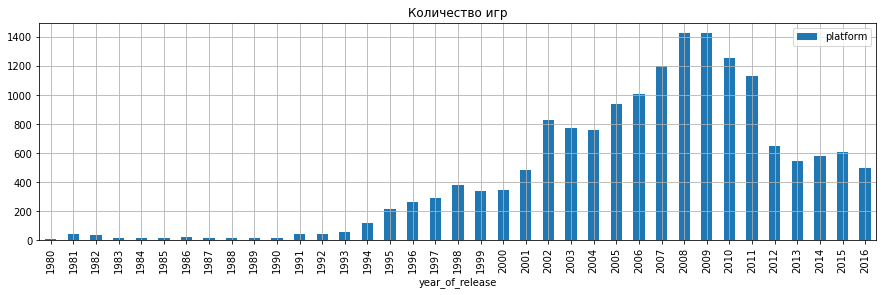

In [68]:
games.pivot_table(
    index='year_of_release', values='platform', aggfunc='count'
).plot(
    kind='bar',
    title="Количество игр",
    figsize=(15,4),
    grid=True
);

До 1991 г. количество игр незначительно. Рост начинается с 1993г с локальным пиком в 1998, затем заметный прирост в 2002 г. с небольшим спадом к 2004 и новый значительный рост с 2005г. 

Максимальное количество игр было выпущено в 2008-2009гг., после чего наблюдается постепенный спад. С 2012 г. число выпускаемых игр сильно снижается (до у ровня начала 2000х) и примерно на этом уровне с плавным снижением остается до 2016г.

Полагаю, стремительный рост 2000хх связан с мощным развитием интернета.

А спад 2010х - соотв. с развитием смартфонов, и переходом компьютерных игроков в гаджет-игроков в значительной степени. 

In [69]:
# Сколько игр было до 1994 года (без учета пропусков)

games.query('year_of_release <= 1993')['year_of_release'].count()

365

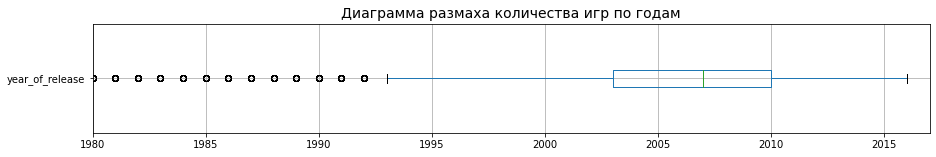

In [70]:
# Построим диаграмму размаха количества игр по годам

fig, ax = plt.subplots(figsize = (15,2))
ax = games[['year_of_release']].boxplot(vert = False, ax = ax)
ax.set_title('Диаграмма размаха количества игр по годам', size = 14)
ax.set_xlim(1980,2017);

Значения до 1994 г на диаграмме выглядят как выбросы. Хотя это был важный этап развития индустрии, для анализа такие разрозненные и стихийные данные не подходят. Предлагаю оставить период с 1994 по 2016г. (посмотрим по другим параметрам).

### Продажи игр по годам.

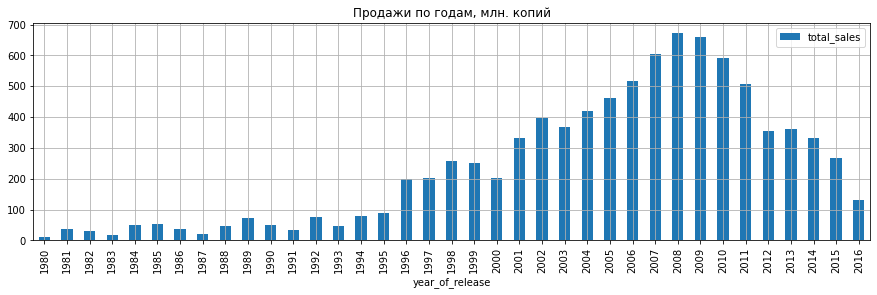

In [71]:
# Рассмотрим Продажи по годам

games.pivot_table(
    index='year_of_release', values='total_sales', aggfunc='sum'
).plot(
    kind='bar',
    title="Продажи по годам, млн. копий",
    figsize=(15,4),
    grid=True
);

Динамика продаж естественным образом повторяет динамику количетсва игр по тем же причинам. График более равномерно распределен.
Количество продаж снижается до уровня конца 90х. 2016г не совсем показателен, поскольку данные не полные.

In [72]:
# Какую долю это составляет от общего объема продаж.

round((games.query('year_of_release <= 1993')['total_sales'].sum() / games['total_sales'].sum())*100, 2)

6.57

Продажи за этот период составляют 6,5% (без пропусков) или 7,47% (с пропусками) от общей за все годы.

Довольно большое число. Посмотрим дальше, как быть с этой информацией.

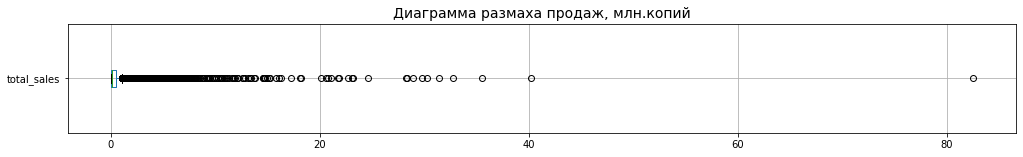

In [73]:
# Построим диаграмму размаха Продаж, за весь период

fig, ax = plt.subplots(figsize = (17,2))
ax = games[['total_sales']].boxplot(vert = False, ax = ax)
ax.set_title('Диаграмма размаха продаж, млн.копий', size = 14);
#ax.set_xlim(0,4);

Максимальные значения продаж за все время наблюдений составляют 82 млн. копий.

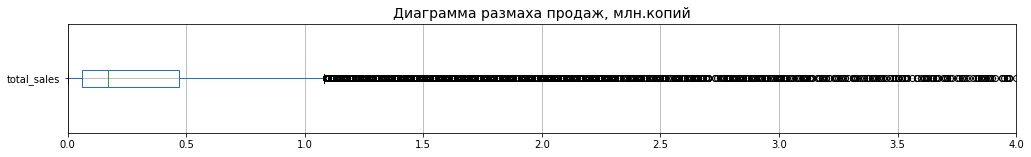

In [74]:
# Зададим ограничение по оси х

fig, ax = plt.subplots(figsize = (17,2))
ax = games[['total_sales']].boxplot(vert = False, ax = ax)
ax.set_title('Диаграмма размаха продаж, млн.копий', size = 14)
ax.set_xlim(0,4);

Получается, что нормальные значения продаж до 1,1 млн. копий.

In [75]:
games['total_sales'].describe()

count   16458.00
mean        0.54
std         1.56
min         0.00
25%         0.06
50%         0.17
75%         0.47
max        82.54
Name: total_sales, dtype: float64

Медианное значение продаж составляет 0,17 млн.копий. И по основной части игр (75%) продажи достигают 0,47 млн.копий.

### Продажи игр по платформам. Жизненный цикл платформ.

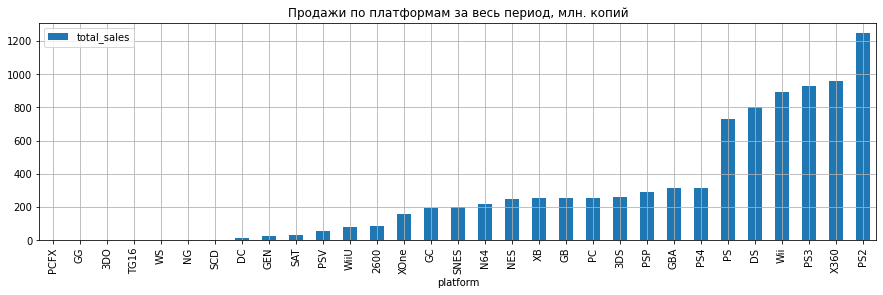

In [76]:
games.pivot_table(index=['platform'], values='total_sales', aggfunc='sum').sort_values(by='total_sales').plot(
    kind='bar',
    title="Продажи по платформам за весь период, млн. копий",
    figsize=(15,4),
    grid=True,
);

Рассмотрим продажи по 6 платформам с наибольшими продажами: PS2, X360, PS3, Wii, DS, PS.

In [77]:
# Создадим новый объект для ТОП-6 платформ

top_6 = games.pivot_table(
    index='platform',
    values='total_sales',
    aggfunc=('sum')
).sort_values(by='total_sales', ascending=False).head(6).T

display(top_6)

platform,PS2,X360,PS3,Wii,DS,PS
total_sales,1247.28,961.30,931.33,891.18,802.79,727.58


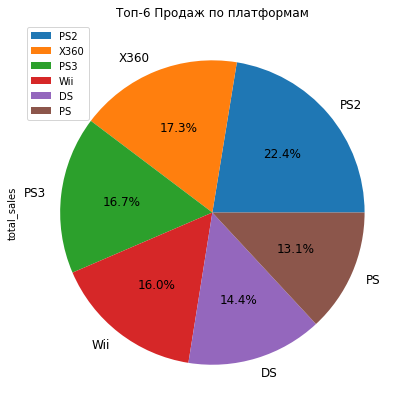

In [78]:
# И ТОП-6 в другом варианте, с долями

games.pivot_table(
    index='platform',
    values='total_sales',
    aggfunc=('sum')
).sort_values(
    by='total_sales', ascending=False
).head(6).plot(
    title='Топ-6 Продаж по платформам',
    y='total_sales',
    kind='pie',
    fontsize = 12,
    autopct='%1.1f%%',
    figsize=(7,7),
);

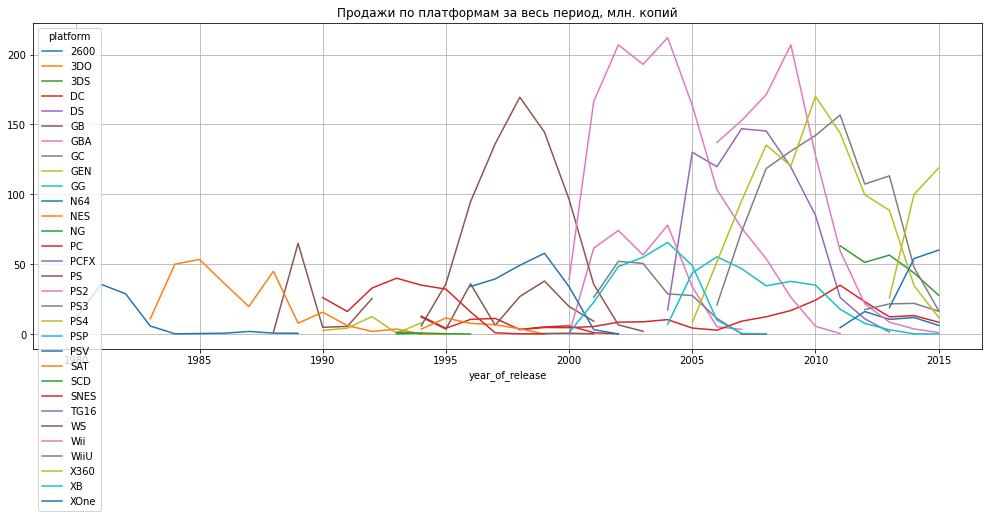

In [79]:
# Посмотрим, как распределяются продажи всех платформ по годам

games.query('1980 <= year_of_release <= 2015').pivot_table(
    index=['year_of_release'], values='total_sales', columns='platform', aggfunc='sum'
).plot(
    kind='line',
    title="Продажи по платформам за весь период, млн. копий",
    figsize=(17,6),
    grid=True, 
);

Мы видим, что платформы проходят период активного роста, пик и спад. Затем появляются новые. Наибольший уровень продаж отмечается с 2000 по 2005 гг (PS2), 2006 - 2010 (Wii), 1995 - 2000 (PS), 2008 - 2011(X360, PS3).

При этом к 2015 году все платформы, появившиеся до 2010г близки к финальной стадии существования. 

Новые платформы с 2011 г хоть и появляются в достаточно большом количестве, но уровень продаж их намного ниже, чем у лидеров 2000-2010х гг. 
Относительно новых платформ , потенциально не достигших совего пика, я бы отметила 3: PS4, XOne, WiiU. И пока еще относительно продаваемые, но , похоже, прошедшие пик активности: PCV, 3DS

Рассмотрим топ-6 на подобном графике.

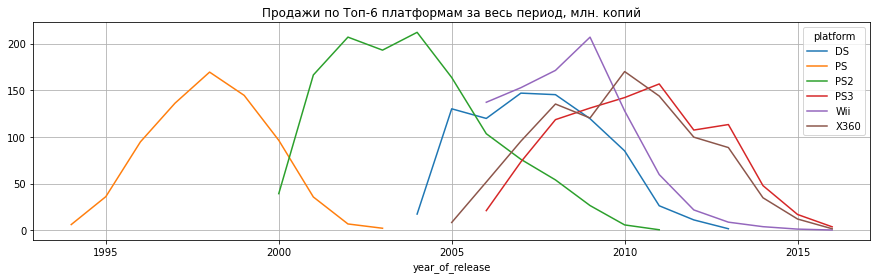

In [80]:
# Посмотрим, как распределяются ТОП-6 платформы по годам

games.query('1990 <= year_of_release <= 2016 and platform in @top_6').pivot_table(
    index=['year_of_release'], values='total_sales', columns='platform', aggfunc='sum'
).plot(
    kind='line',
    title="Продажи по Топ-6 платформам за весь период, млн. копий",
    figsize=(15,4),
    grid=True, 
);

Мы видим, что основные платформы живут примерно 8-10 лет.

Узнаем средний срок жизни игровых платформ.

In [81]:
# Создадим новый объект

g_time = games.query('1980 <= year_of_release <= 2015').pivot_table(
    index=['platform'], values=['total_sales', 'year_of_release'], aggfunc={'total_sales':'sum', 'year_of_release':['min', 'max']}
)

In [82]:
# Добавим колонку со сроком жизни

g_time['life_time'] = g_time['year_of_release']['max'] - g_time['year_of_release']['min']

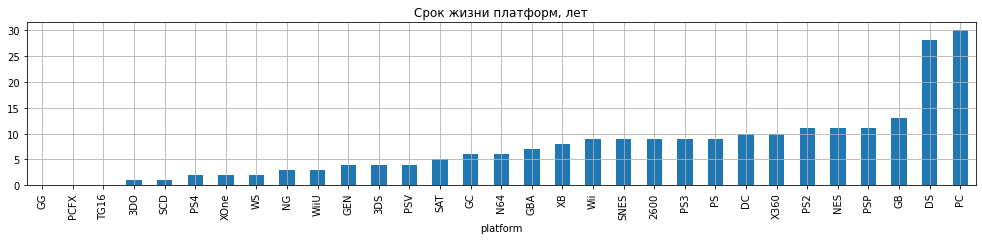

In [83]:
# И построим график

g_time['life_time'].sort_values().plot(
    x='platform',
    kind='bar',
    title="Срок жизни платформ, лет",
    figsize=(17,3),
    grid=True,
);

In [84]:
g_time.T

platform               2600     3DO     3DS      DC      DS      GB     GBA  \
total_sales     sum   86.48    0.10  242.67   15.95  802.79  254.43  312.88   
year_of_release max 1989.00 1995.00 2015.00 2008.00 2013.00 2001.00 2007.00   
                min 1980.00 1994.00 2011.00 1998.00 1985.00 1988.00 2000.00   
life_time              9.00    1.00    4.00   10.00   28.00   13.00    7.00   

platform                 GC     GEN      GG     N64     NES      NG      PC  \
total_sales     sum  197.03   28.35    0.04  218.01  251.05    1.44  250.51   
year_of_release max 2007.00 1994.00 1992.00 2002.00 1994.00 1996.00 2015.00   
                min 2001.00 1990.00 1992.00 1996.00 1983.00 1993.00 1985.00   
life_time              6.00    4.00    0.00    6.00   11.00    3.00   30.00   

platform               PCFX      PS     PS2     PS3     PS4     PSP     PSV  \
total_sales     sum    0.03  727.58 1247.28  927.73  244.89  289.54   49.56   
year_of_release max 1996.00 2003.00 2011.00 2015.00 2015.00 2015.00 2015.00   
                min 1996.00 1994.00 2000.00 2006.00 2013.00 2004.00 2011.00   
life_time              0.00    9.00   11.00    9.00    2.00   11.00    4.00   

platform                SAT     SCD    SNES    TG16      WS     Wii    WiiU  \
total_sales     sum   33.59    1.86  200.04    0.16    1.42  891.00   77.59   
year_of_release max 1999.00 1994.00 1999.00 1995.00 2001.00 2015.00 2015.00   
                min 1994.00 1993.00 1990.00 1995.00 1999.00 2006.00 2012.00   
life_time              5.00    1.00    9.00    0.00    2.00    9.00    3.00   

platform               X360      XB    XOne  
total_sales     sum  959.78  252.66  133.17  
year_of_release max 2015.00 2008.00 2015.00  
                min 2005.00 2000.00 2013.00  
life_time             10.00    8.00    2.00

In [85]:
g_time['life_time'].describe()

count   31.00
mean     7.32
std      6.95
min      0.00
25%      2.50
50%      6.00
75%      9.50
max     30.00
Name: life_time, dtype: float64

Если брать весь период наблюдений, то медианный срок жизни платформ составляет 6 лет. 25% платформ живут до 3х лет, и 75 % - до 10 лет.

При этом есть платформы - однодневки, которые не протянули и год. И есть 2 долгожителя - PC (30 лет) и DS (продержалась 28 лет).

### Актуальный период и Топ-5 2015.

Исходя из количества игр, продаж, количества и развития плтаформ, а также принимая во внимания развитие персональных компьютеров и распространенность интернета, определим актуальный период от 2012 по 2015гг.

И чтобы предыдущие периоды не мешались под руками, создадим новый объект с учетом этого критерия.

In [86]:
games_act = games.query('year_of_release >= 2012')


In [87]:
games_act.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2885 entries, 16 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             2885 non-null   object  
 1   platform         2885 non-null   object  
 2   year_of_release  2885 non-null   int64   
 3   genre            2885 non-null   object  
 4   na_sales         2885 non-null   float64 
 5   eu_sales         2885 non-null   float64 
 6   jp_sales         2885 non-null   float64 
 7   other_sales      2885 non-null   float64 
 8   critic_score     2885 non-null   float64 
 9   user_score       2885 non-null   float64 
 10  rating           2885 non-null   category
 11  total_sales      2885 non-null   float64 
dtypes: category(1), float64(7), int64(1), object(3)
memory usage: 273.6+ KB


In [88]:
# Объем оставшихся данных

round((games_act.shape[0] / len_original_games)*100, 2)

17.26

In [89]:
games_act.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
count,2885.00,2885.00,2885.00,2885.00,2885.00,2885.00,2885.00,2885.00
mean,2013.92,0.20,0.18,0.07,0.05,32.29,2.63,0.50
std,1.41,0.57,0.51,0.24,0.16,37.47,4.42,1.25
min,2012.00,0.00,0.00,0.00,0.00,-1.00,-2.00,0.01
25%,2013.00,0.00,0.00,0.00,0.00,-1.00,-2.00,0.04
50%,2014.00,0.03,0.03,0.01,0.01,-1.00,3.50,0.12
75%,2015.00,0.17,0.14,0.05,0.04,73.00,7.10,0.43
max,2016.00,9.66,9.09,4.39,3.96,97.00,9.30,21.05


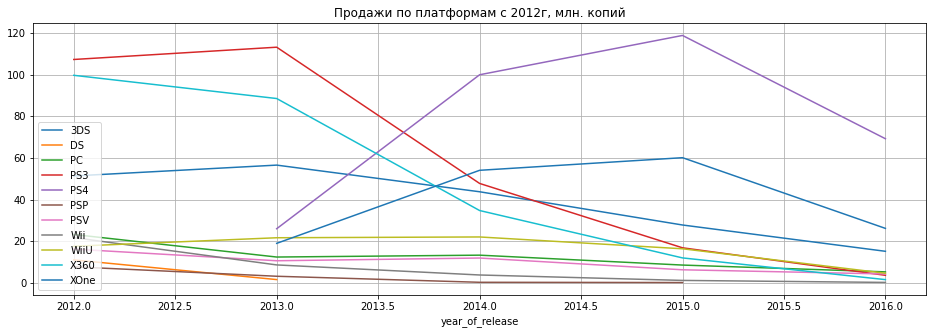

In [90]:
games_act.query('year_of_release <= 2016').pivot_table(
    index=['year_of_release'], values='total_sales', columns='platform', aggfunc='sum'
).plot(
    kind='line',
    title="Продажи по платформам c 2012г, млн. копий",
    figsize=(16,5),
    grid=True, 
);
plt.legend(loc='lower left');

In [91]:
# Лидеры продаж с 2015г

g_act_top_5 = games_act.query('year_of_release >= 2015').groupby('platform')['total_sales'].sum().sort_values(ascending=False).to_frame().head().T

In [92]:
# Топ-5 продаж с 2015 г.

g_act_top_5

platform,PS4,XOne,3DS,WiiU,PS3
total_sales,188.15,86.29,42.92,20.95,20.42


Можно отметить, что в топ-5 входят: PS4, XOne, 3DS, WiiU, PS3, PC. Потенциально прибыльными я бы назвала только PS4 и XOne, может быть еще WiiU. Остальные уже прошли пик продаж и идут на спад или находятся в стабильно низких значениях продаж.

Построим диаграмму размаха Продаж для выбранных ТОП-5 за актуальный период наблюдений.

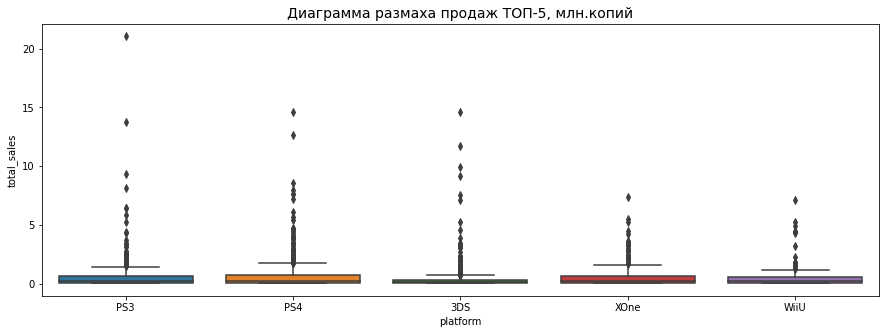

In [93]:
# Построим Boxplot по основным платформам

plt.figure(figsize=(15,5))

sns.boxplot(x='platform', y='total_sales', data=games_act.query('platform in @g_act_top_5'))
plt.title('Диаграмма размаха продаж ТОП-5, млн.копий', size = 14);

Макисмальные значения продаж относятся к выбросам. тем не менее здесь самые высокие продажи наблюдались у PS3 - около 22 млн. копий. На 2м месте: PS4 и 3DS - около 15 млн. копий. И затем XOne и WiiU - около 7,5 млн.копий.

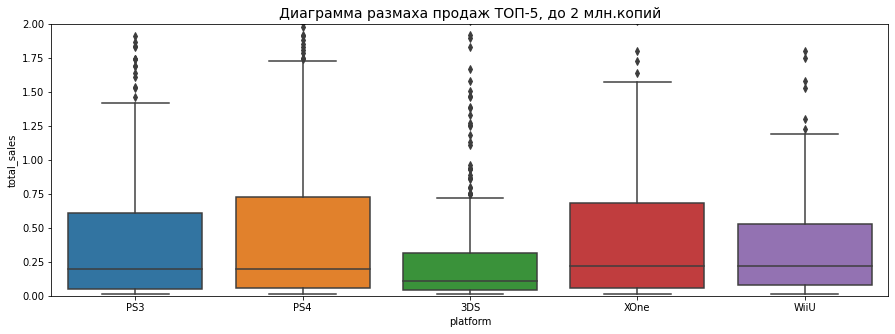

In [94]:
# Ограничим верхний предел продаж

plt.figure(figsize=(15,5))

sns.boxplot(x='platform', y='total_sales', data=games_act.query('platform in @g_act_top_5'))
plt.ylim(0,2)
plt.title('Диаграмма размаха продаж ТОП-5, до 2 млн.копий', size = 14);

Без учета аномальных значений:
Максимальный уровень продаж у PS4~ 1,75 млн. копий, на 2м месте - XOne~ 1,6 млн.копий. В ТОП-5 отличается 3DS - значительно ниже остальных - наибольший уровень продаж для этой платформы ~ 0,75 млн.копий. (Возможно связано с неудачным стартом - когда у пользователей в Америке и Европе в первой версии прошивки часто возникали ошибки, требующие перезагрузки).

Медианные значения продаж у 4х основных платформ примерно на одном урове ~ 0,2 млн.копий, у 3DS почти в 2 раза ниже ~ 0,12 млн. копий

In [95]:
# Выведем числовые характеристики продаж по ТОП-5

games_act.query('platform in @g_act_top_5').groupby('platform')['total_sales'].describe().sort_values(by='count', ascending=False).T

platform,PS3,3DS,PS4,XOne,WiiU
count,492.00,396.00,392.00,247.00,147.00
mean,0.59,0.49,0.80,0.65,0.56
std,1.46,1.39,1.61,1.04,1.06
min,0.01,0.01,0.01,0.01,0.01
25%,0.05,0.04,0.06,0.06,0.08
50%,0.20,0.11,0.20,0.22,0.22
75%,0.61,0.31,0.73,0.69,0.53
max,21.05,14.60,14.63,7.39,7.09


По Количеству проданных игр лидирует PS3, минимальное число продаж у WiiU. До 25% продаж основных 4х платформ составлят 0,05 -0,06 млн.копий (PS3, PS4, XOne) до 0,08 (WiiU). 75% продаж основных 4х платформ варьируются от 0,53 (WiiU) и 0,61 (PS3) до 0,69 (XOne) - 0,73 (PS4). 
3DS - платформа с минимальными продажами из ТОП-5. Здесь показатели сильно ниже остальных: 25% - до 0,04 млн.копий и 75% до 0,31 млн.копий.

### Влияние на продажи отзывов пользователей и критиков.

Возьмем для исследования данного параметра платформу PS3, как самую продаваемую в актуальном периоде.

Построим диаграмму рассеяния для параметров critic_score - total_sales

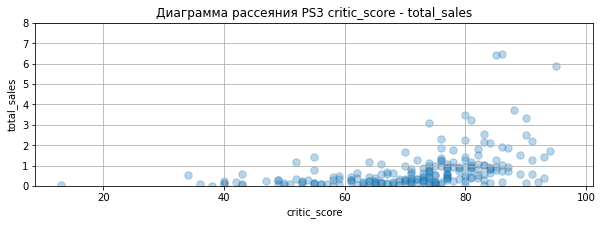

In [96]:
games_act.query(
    'platform == "PS3" and critic_score >= 0'
).plot.scatter(
    x='critic_score',
    y='total_sales',
    ylim=(0, 8),
    s=55,
    grid=True,
    figsize=(10,3),
    alpha=0.3
)
plt.title('Диаграмма рассеяния PS3 critic_score - total_sales', size=12);

Получается, чем выше отзывы критиков, тем лучше продается игра.

In [97]:
# Рассчитаем коэффициент корреляции

games_act.query('platform == "PS3" and critic_score >= 0')['critic_score'].corr(games_act.query('platform == "PS3" and critic_score >= 0')['total_sales'])

0.3341517575509856

Судя по коээфициенту корреляции, есть положительная прямая связь, однако она ниже среднего уровня. Т.е. зависимость здесь не линейная, а более сложного порядка.

Построим диаграмму рассеяния для параметров user_score - total_sales.

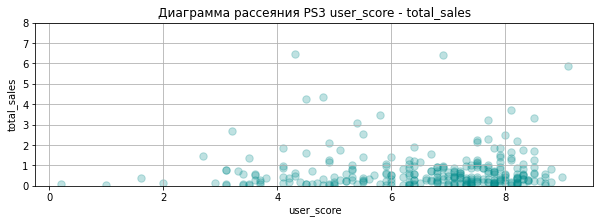

In [98]:
games_act.query(
    'platform == "PS3" and user_score >= 0'
).plot.scatter(
    x='user_score',
    y='total_sales',
    ylim=(0, 8),
    s=55,
    c='darkcyan',
    grid=True,
    figsize=(10,3),
    alpha=0.25
)
plt.title('Диаграмма рассеяния PS3 user_score - total_sales', size=12);

Диаграмма показывает похожий результат, как и в предыдущем случае. Чем выше отзывы, тем выше продажи игр. А может и наоборот, scatter plot направление зависимости не показывает.

In [99]:
# Рассчитаем коэффициент корреляции

games_act.query('platform == "PS3" and user_score >= 0')['user_score'].corr(games_act.query('platform == "PS3" and user_score >= 0')['total_sales'])

-0.006205767686051523

Здесь коэффициент корреляции совсем ничтожный, и даже отрицательный. Т.е. прямой линейной зависимости нет. Если и есть какая-то связь, то она совсем не линейная, а более сложная.

Построим матрицу рассеяния по остальным платформам из ТОП-5.

**3DS**

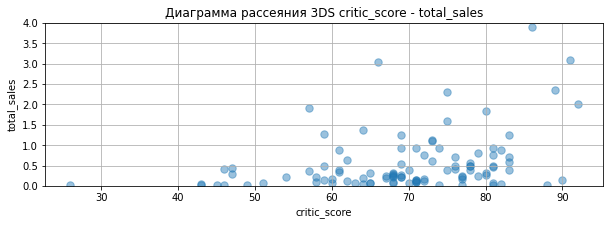

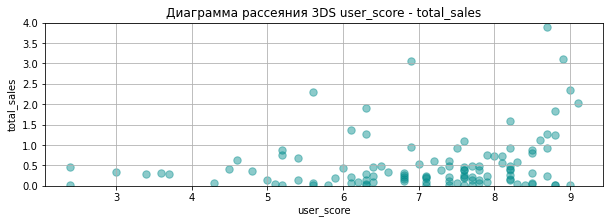

In [100]:
games_act.query(
    'platform == "3DS" and critic_score >= 0'
).plot.scatter(
    x='critic_score',
    y='total_sales',
    ylim=(0, 4),
    s=55,
    grid=True,
    figsize=(10,3),
    alpha=0.45
)
plt.title('Диаграмма рассеяния 3DS critic_score - total_sales', size=12);

games_act.query(
    'platform == "3DS" and user_score >= 0'
).plot.scatter(
    x='user_score',
    y='total_sales',
    ylim=(0, 4),
    s=55,
    c='darkcyan',
    grid=True,
    figsize=(10,3),
    alpha=0.45
)
plt.title('Диаграмма рассеяния 3DS user_score - total_sales', size=12);

plt.show();

In [101]:
# Рассчитаем коэффициент корреляции critic_score

games_act.query('platform == "3DS" and critic_score >= 0')['critic_score'].corr(games_act.query('platform == "3DS" and critic_score >= 0')['total_sales'])

0.3208028695360785

In [102]:
# Рассчитаем коэффициент корреляции user_score

games_act.query('platform == "3DS" and user_score >= 0')['user_score'].corr(games_act.query('platform == "3DS" and user_score >= 0')['total_sales'])

0.19758263411038599

По 3DS ситуация иная. Отзывы критиков также имеют линейную пряму положительную зависимость ниже среднего. Но гораздо более знаяимы отзывы пользователей: прямая положительная зависимость, хоть и очень слабая.

**PS4**

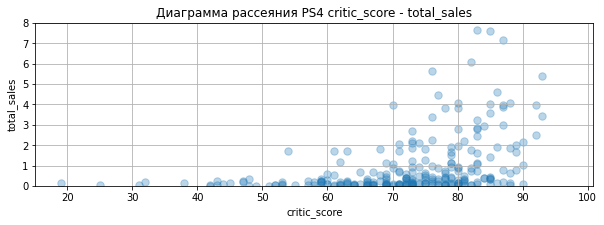

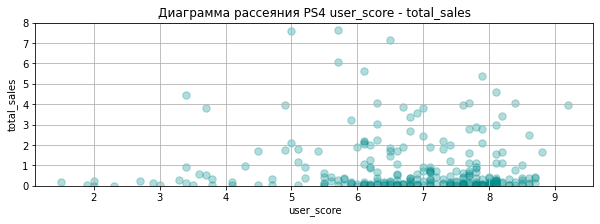

In [103]:
games_act.query(
    'platform == "PS4" and critic_score >= 0'
).plot.scatter(
    x='critic_score',
    y='total_sales',
    ylim=(0, 8),
    s=55,
    grid=True,
    figsize=(10,3),
    alpha=0.3
)
plt.title('Диаграмма рассеяния PS4 critic_score - total_sales', size=12);

games_act.query(
    'platform == "PS4" and user_score >= 0'
).plot.scatter(
    x='user_score',
    y='total_sales',
    ylim=(0, 8),
    s=55,
    c='darkcyan',
    grid=True,
    figsize=(10,3),
    alpha=0.3
)
plt.title('Диаграмма рассеяния PS4 user_score - total_sales', size=12);

plt.show();

In [104]:
# Рассчитаем коэффициент корреляции critic_score

games_act.query('platform == "PS4" and critic_score >= 0')['critic_score'].corr(games_act.query('platform == "PS4" and critic_score >= 0')['total_sales'])

0.40656790206178095

In [105]:
# Рассчитаем коэффициент корреляции user_score

games_act.query('platform == "PS4" and user_score >= 0')['user_score'].corr(games_act.query('platform == "PS4" and user_score >= 0')['total_sales'])

-0.031957110204556376

Коэффициенты корреляции по платформе PS4 незначительно выше чем по PS3: Отзывы критиков играют чуть большую роль. Отзывы пользователей скорее никак не влияют на продажи.

**XOne**

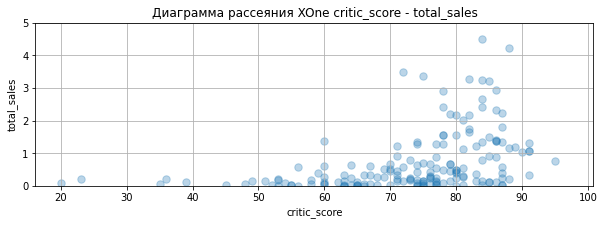

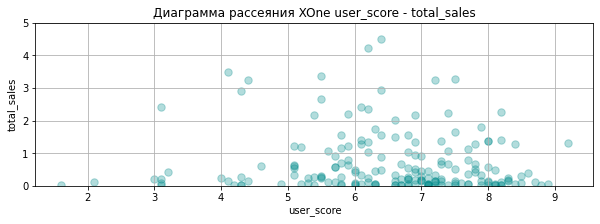

In [106]:
games_act.query(
    'platform == "XOne" and critic_score >= 0'
).plot.scatter(
    x='critic_score',
    y='total_sales',
    ylim=(0, 5),
    s=55,
    grid=True,
    figsize=(10,3),
    alpha=0.3
)
plt.title('Диаграмма рассеяния XOne critic_score - total_sales', size=12);

games_act.query(
    'platform == "XOne" and user_score >= 0'
).plot.scatter(
    x='user_score',
    y='total_sales',
    ylim=(0, 5),
    s=55,
    c='darkcyan',
    grid=True,
    figsize=(10,3),
    alpha=0.3
)
plt.title('Диаграмма рассеяния XOne user_score - total_sales', size=12);

plt.show();

In [107]:
# Рассчитаем коэффициент корреляции

games_act.query('platform == "XOne" and critic_score >= 0')['critic_score'].corr(games_act.query('platform == "XOne" and critic_score >= 0')['total_sales'])

0.4169983280084017

In [108]:
# Рассчитаем коэффициент корреляции

games_act.query('platform == "XOne" and user_score >= 0')['user_score'].corr(games_act.query('platform == "XOne" and user_score >= 0')['total_sales'])

-0.06892505328279414

XOne аналогична PS4: Отзывы критиков ниже среднего, но зависимость прямая положительная. Отзывы пользователей скорее не влияют на продажи.

**WiiU**

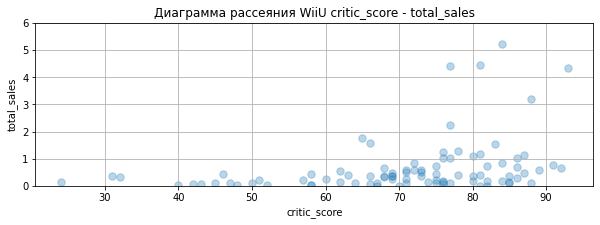

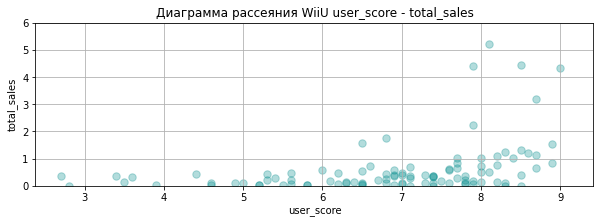

In [109]:
games_act.query(
    'platform == "WiiU" and critic_score >= 0'
).plot.scatter(
    x='critic_score',
    y='total_sales',
    ylim=(0, 6),
    s=55,
    grid=True,
    figsize=(10,3),
    alpha=0.3
)
plt.title('Диаграмма рассеяния WiiU critic_score - total_sales', size=12);

games_act.query(
    'platform == "WiiU" and user_score >= 0'
).plot.scatter(
    x='user_score',
    y='total_sales',
    ylim=(0, 6),
    s=55,
    c='darkcyan',
    grid=True,
    figsize=(10,3),
    alpha=0.3
)
plt.title('Диаграмма рассеяния WiiU user_score - total_sales', size=12);

plt.show();

In [110]:
# Рассчитаем коэффициент корреляции

games_act.query('platform == "WiiU" and critic_score >= 0')['critic_score'].corr(games_act.query('platform == "WiiU" and critic_score >= 0')['total_sales'])

0.34837976012017485

In [111]:
# Рассчитаем коэффициент корреляции

games_act.query('platform == "WiiU" and user_score >= 0')['user_score'].corr(games_act.query('platform == "WiiU" and user_score >= 0')['total_sales'])

0.4002190202148617

Платформа WiiU отличается от предыдущих. Здесь зависимость продаж от отзывов прямая положительная ниже среднего, причем отзывы критиков имеют меньшее влияние, чем отзывы пользователей. А вот корреляция продаж и отзывов пользователей максимальная из ТОП-5, составляет целых 40%.

### Распределение игр по жанрам.

Рассмотрим суммарные продажи игр по жанрам.

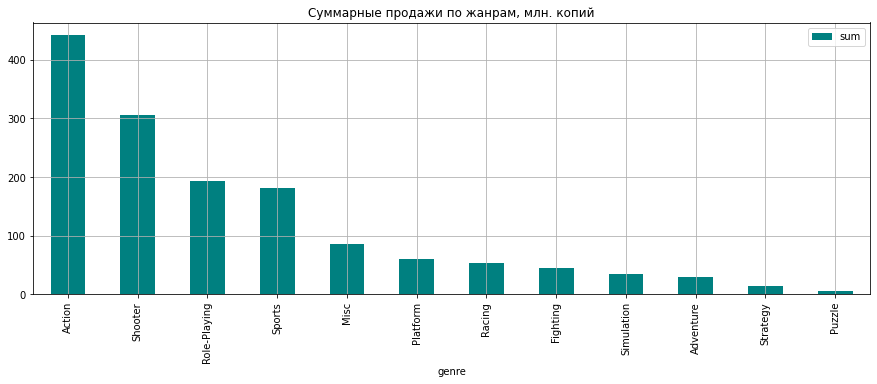

In [112]:
# Суммарные продажи игр по жанрам

g_genre = games_act.pivot_table(
    index='genre',
    values='total_sales',
    aggfunc=('sum', 'count')
).reset_index(
).sort_values(by='sum', ascending= False).plot(
    kind='bar',
    x='genre',
    y='sum',
    color='Teal',
    figsize=(15,5),
    grid=True
)
plt.title('Суммарные продажи по жанрам, млн. копий');


В целом по сумме продаж лидером является Action, затем Shooter и 3-е место занимают Role-Playing и Sports.

Возьмем медианные значения, чтобы исключить влияние выбросов и аномальных значений.

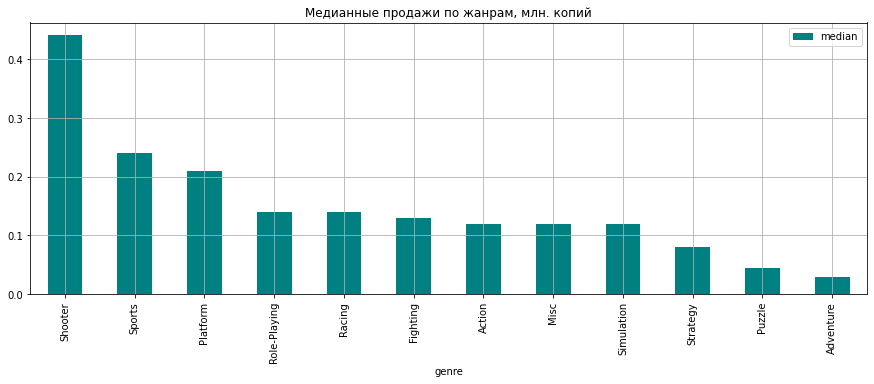

In [113]:
# Продажи игр по жанрам

g_genre = games_act.pivot_table(
    index='genre',
    values='total_sales',
    aggfunc=('median', 'count')
).reset_index(
).sort_values(by='median', ascending= False).plot(
    kind='bar',
    x='genre',
    y='median',
    color='Teal',
    figsize=(15,5),
    grid=True
)
plt.title('Медианные продажи по жанрам, млн. копий');


Наиболее популярным жанром является Shooter, который почти в 2 раза превышает покзатели 2 и 3 места. На 2м месте - Sports, на 3-м - Platform. далее примерно на одном уровне Role-Playing и Racing.

Наименее популярны игры жанра Strategy, Puzzle, Adventure.

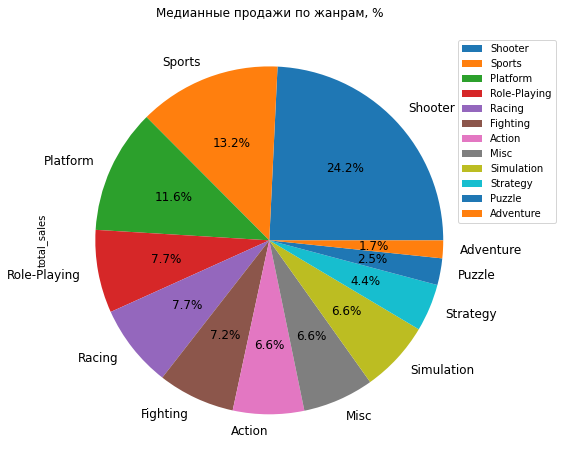

In [114]:
# Распределение медианных продаж игр по жанрам, с долями

games_act.pivot_table(
    index='genre',
    values='total_sales',
    aggfunc=('median')
).sort_values(
    by='total_sales', ascending=False
).plot(
    title='Медианные продажи по жанрам, %',
    y='total_sales',
    kind='pie',
    fontsize = 12,
    autopct='%1.1f%%',
    figsize=(8,8),
)
plt.legend(bbox_to_anchor=[1.17, 0.75], loc='right');

3 наиболее популярных жанра составляют почти половину общих продаж.

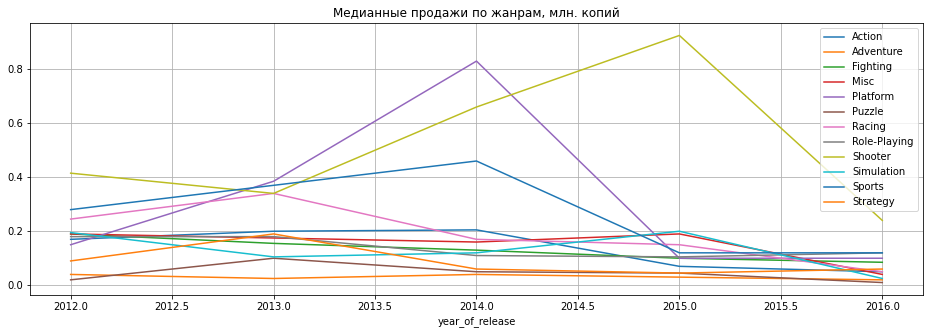

In [115]:
# И по годам

games_act.pivot_table(
    index=['year_of_release'], values='total_sales', columns='genre', aggfunc='median'
).plot(
    kind='line',
    title="Медианные продажи по жанрам, млн. копий",
    figsize=(16,5),
    grid=True, 
);
plt.legend(loc='best');

Лидеры в актуальном периоде: Shooter (пик популярности в 2015г), Platform и затем Action (пик в 2014г)
Стабильно минимально популярные во все времена: Adventure, Puzzle, Strategy. На них вместе приходится около 9% продаж.

Рассмотрим популярность жанров по ТОП-5 платформам.

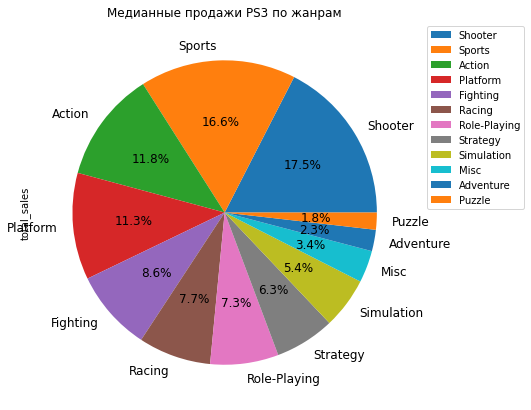

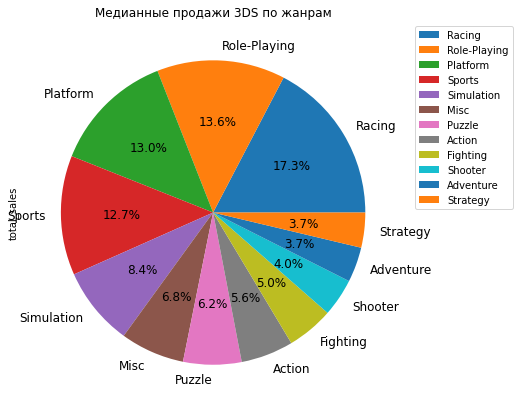

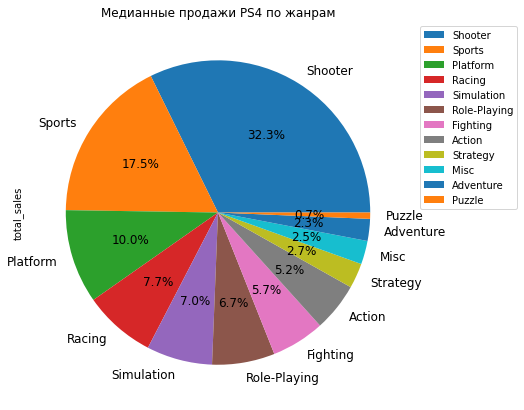

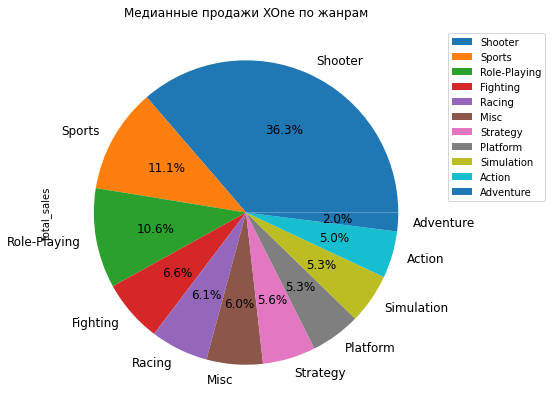

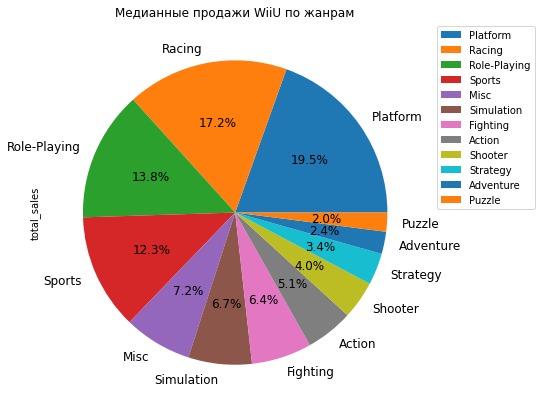

In [116]:
games_act.query('platform == "PS3"').pivot_table(
    index='genre',
    values='total_sales',
    aggfunc=('median')
).sort_values(
    by='total_sales', ascending=False
).plot(
    title='Медианные продажи PS3 по жанрам',
    y='total_sales',
    kind='pie',
    fontsize = 12,
    autopct='%1.1f%%',
    figsize=(7,7),
)
plt.legend(bbox_to_anchor=[1.3, 0.75], loc='right');

games_act.query('platform == "3DS"').pivot_table(
    index='genre',
    values='total_sales',
    aggfunc=('median')
).sort_values(
    by='total_sales', ascending=False
).plot(
    title='Медианные продажи 3DS по жанрам',
    y='total_sales',
    kind='pie',
    fontsize = 12,
    autopct='%1.1f%%',
    figsize=(7,7),
)
plt.legend(bbox_to_anchor=[1.3, 0.75], loc='right');

games_act.query('platform == "PS4"').pivot_table(
    index='genre',
    values='total_sales',
    aggfunc=('median')
).sort_values(
    by='total_sales', ascending=False
).plot(
    title='Медианные продажи PS4 по жанрам',
    y='total_sales',
    kind='pie',
    fontsize = 12,
    autopct='%1.1f%%',
    figsize=(7,7),
)
plt.legend(bbox_to_anchor=[1.3, 0.75], loc='right');

games_act.query('platform == "XOne"').pivot_table(
    index='genre',
    values='total_sales',
    aggfunc=('median')
).sort_values(
    by='total_sales', ascending=False
).plot(
    title='Медианные продажи XOne по жанрам',
    y='total_sales',
    kind='pie',
    fontsize = 12,
    autopct='%1.1f%%',
    figsize=(7,7),
)
plt.legend(bbox_to_anchor=[1.3, 0.75], loc='right');

games_act.query('platform == "WiiU"').pivot_table(
    index='genre',
    values='total_sales',
    aggfunc=('median')
).sort_values(
    by='total_sales', ascending=False
).plot(
    title='Медианные продажи WiiU по жанрам',
    y='total_sales',
    kind='pie',
    fontsize = 12,
    autopct='%1.1f%%',
    figsize=(7,7),
)
plt.legend(bbox_to_anchor=[1.3, 0.75], loc='right');

Распределение игр по жанрам на разных платформах сильно отличается.

## Шаг. Портрет пользователя каждого региона.

### Самые популярные платформы (топ-5).

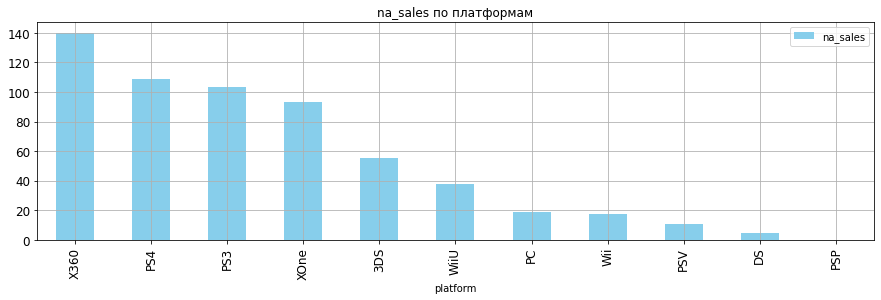

In [117]:
# Распределение игр по платформам na_sales

games_act.pivot_table(
    index='platform',
    values='na_sales',
    aggfunc=('sum')
).sort_values(
    by='na_sales', ascending=False
).plot(
    title='na_sales по платформам',
    y='na_sales',
    kind='bar',
    fontsize = 12,
    #autopct='%1.1f%%',
    figsize=(15,4),
    color='SkyBlue',
    grid=True

);
plt.legend(loc='best');

In [118]:
g_5_na = games_act.pivot_table(
    index='platform',
    values='na_sales',
    aggfunc=('sum')
).sort_values(
    by='na_sales', ascending=False
).head()

Доля продаж ТОП-5 платформ в Северной Америке составляет в общем объеме продаж:

In [119]:
round((g_5_na['na_sales'].sum() / games_act['na_sales'].sum())*100,2)

84.71

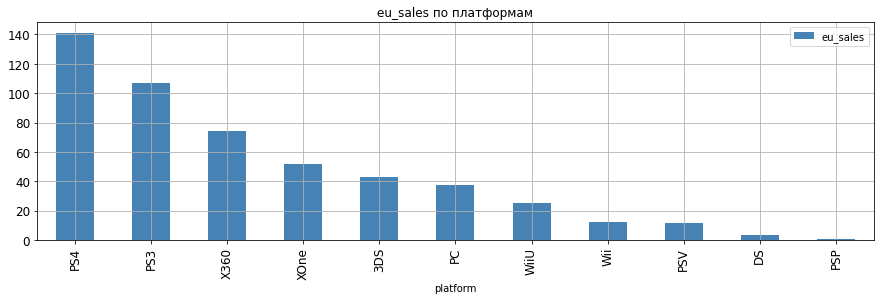

In [120]:
# Распределение игр по платформам eu_sales

games_act.pivot_table(
    index='platform',
    values='eu_sales',
    aggfunc=('sum')
).sort_values(
    by='eu_sales', ascending=False
).plot(
    title='eu_sales по платформам',
    y='eu_sales',
    kind='bar',
    fontsize = 12,
    #autopct='%1.1f%%',
    figsize=(15,4),
    color='SteelBlue',
    grid=True
);
plt.legend(loc='best');

In [121]:
g_5_eu = games_act.pivot_table(
    index='platform',
    values='eu_sales',
    aggfunc=('sum')
).sort_values(
    by='eu_sales', ascending=False
).head(5)

Доля продаж ТОП-5 платформ в Европе составляет в общем объеме продаж:

In [122]:
round((g_5_eu['eu_sales'].sum() / games_act['eu_sales'].sum())*100,2)

82.22

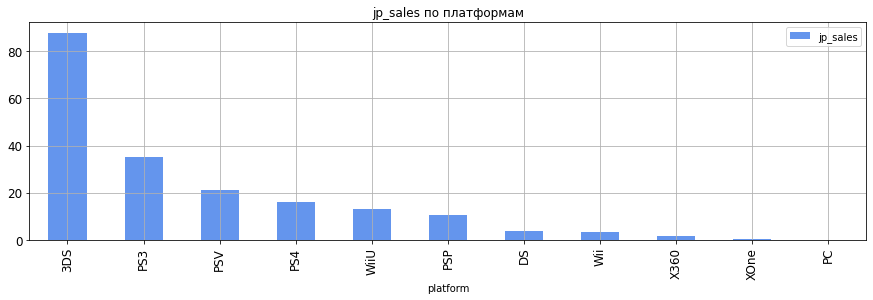

In [123]:
# Распределение игр по платформам jp_sales

games_act.pivot_table(
    index='platform',
    values='jp_sales',
    aggfunc=('sum')
).sort_values(
    by='jp_sales', ascending=False
).plot(
    title='jp_sales по платформам',
    y='jp_sales',
    kind='bar',
    fontsize = 12,
    #autopct='%1.1f%%',
    figsize=(15,4),
    color='CornFlowerBlue',
    grid=True
);
plt.legend(loc='best');

In [124]:
round((games_act.query('platform == "3DS"')['jp_sales'].sum() / games_act['jp_sales'].sum())*100,2)

45.59

In [125]:
g_5_jp = games_act.pivot_table(
    index='platform',
    values='jp_sales',
    aggfunc=('sum')
).sort_values(
    by='jp_sales', ascending=False
).head(5)

Доля продаж ТОП-5 платформ в Европе составляет в общем объеме продаж:

In [126]:
round((g_5_jp['jp_sales'].sum() / games_act['jp_sales'].sum())*100,2)

89.88

В регионе na_sales наиболее популярная платформа X360, в eu_sales - PS4. При этом ТОП-5 включает одни и те же платформы на разных позициях.

jp_sales отличается, как топ-5, так и лидером - DS: одна только эта платформа занимает 45,6% общего объема.

### Самые популярные жанры (топ-5). 

Рассмотрим, есть ли различия в жанрах по рынкам.

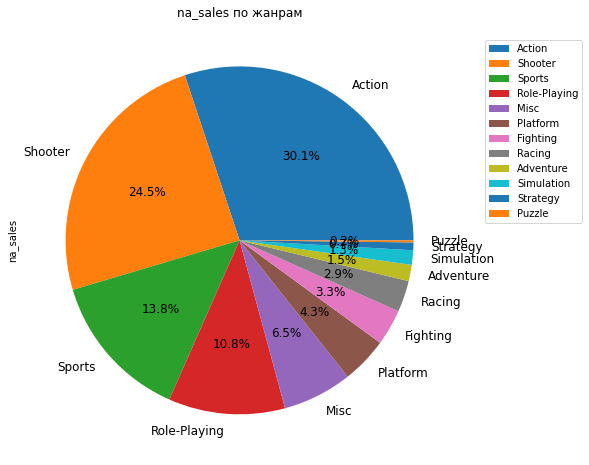

In [127]:
# Распределение игр по жанрам na_sales

games_act.pivot_table(
    index='genre',
    values='na_sales',
    aggfunc=('sum')
).sort_values(
    by='na_sales', ascending=False
).plot(
    title='na_sales по жанрам',
    y='na_sales',
    kind='pie',
    fontsize = 12,
    autopct='%1.1f%%',
    figsize=(8,8),
);
plt.legend(bbox_to_anchor=[1.3, 0.75], loc='right');



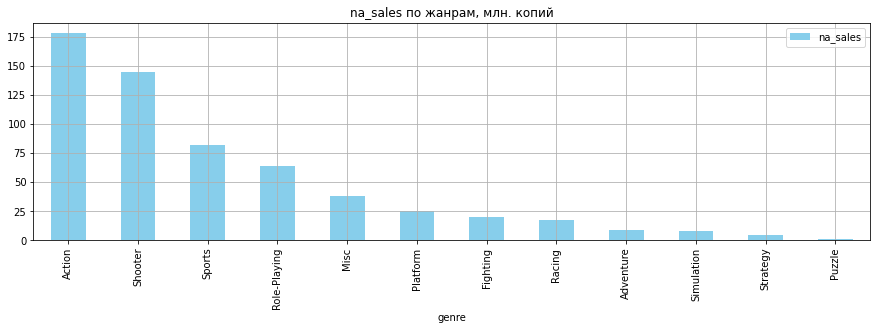

In [128]:
# na_sales

games_act.pivot_table(
    index=['genre'], values='na_sales', aggfunc='sum'
).sort_values(by='na_sales', ascending=False).plot(
    kind='bar',
    title="na_sales по жанрам, млн. копий",
    figsize=(15,4),
    color='SkyBlue',
    grid=True
);
plt.legend(loc='best');

В Северной Америке Action составляет 30% рынка, Shooter - 24% (2 этих жанра = больше половины продаж). Примерно одинаковые доли составляют Sports (13,8%) и Role-Playing (10,8%). Эти 4 жанра занимают 3/4 рынка в Северной Америке.

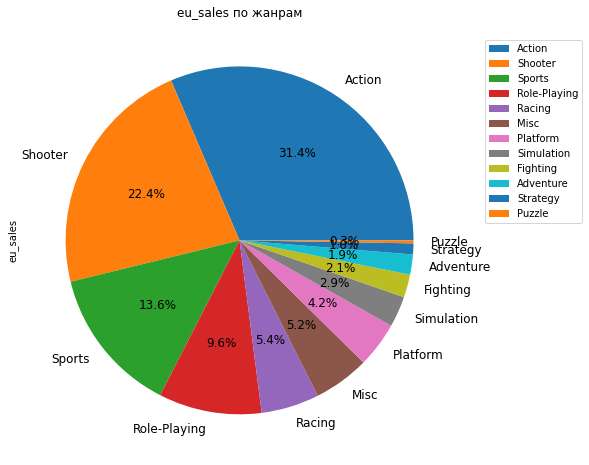

In [129]:
# Распределение игр по жанрам eu_sales

games_act.pivot_table(
    index='genre',
    values='eu_sales',
    aggfunc=('sum')
).sort_values(
    by='eu_sales', ascending=False
).plot(
    title='eu_sales по жанрам',
    y='eu_sales',
    kind='pie',
    fontsize = 12,
    autopct='%1.1f%%',
     figsize=(8,8),
);
plt.legend(bbox_to_anchor=[1.3, 0.75], loc='right');

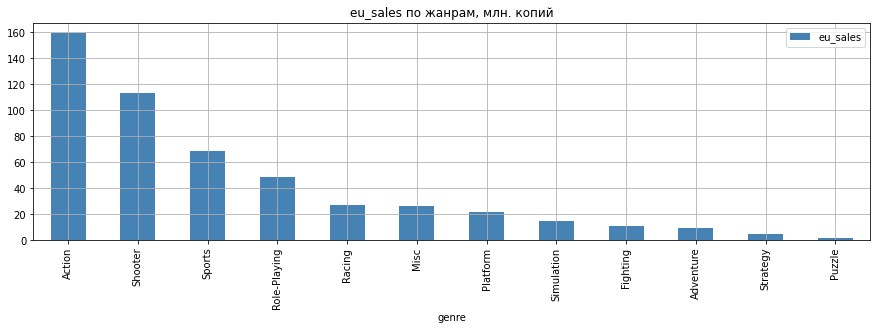

In [130]:
# eu_sales

games_act.pivot_table(
    index=['genre'], values='eu_sales', aggfunc='sum'
).sort_values(
    by='eu_sales', ascending=False
).plot(
    kind='bar',
    title="eu_sales по жанрам, млн. копий",
    figsize=(15,4),
    color='SteelBlue',
    grid=True 
);
plt.legend(loc='best');

В Европе лидеры жанров распределены также, как и в Северной Америке: на 1м месте Action (31%), на 2м - Shooter (22%). Затем идут Sports (13,6%) и Role-Playing (9,6%).

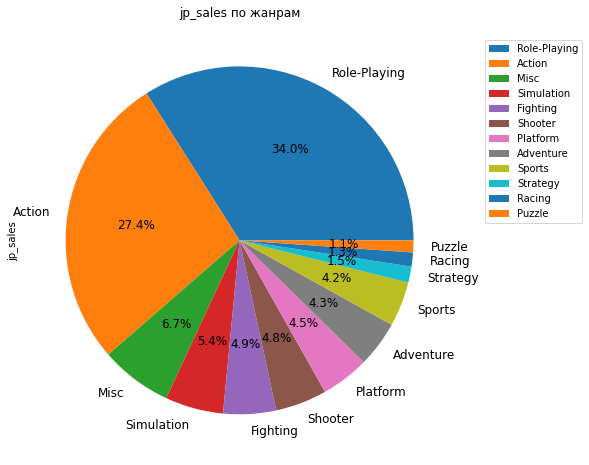

In [131]:
# Распределение игр по жанрам jp_sales

games_act.pivot_table(
    index='genre',
    values='jp_sales',
    aggfunc=('sum')
).sort_values(
    by='jp_sales', ascending=False
).plot(
    title='jp_sales по жанрам',
    y='jp_sales',
    kind='pie',
    fontsize = 12,
    autopct='%1.1f%%',
     figsize=(8,8),
);
plt.legend(bbox_to_anchor=[1.3, 0.75], loc='right');

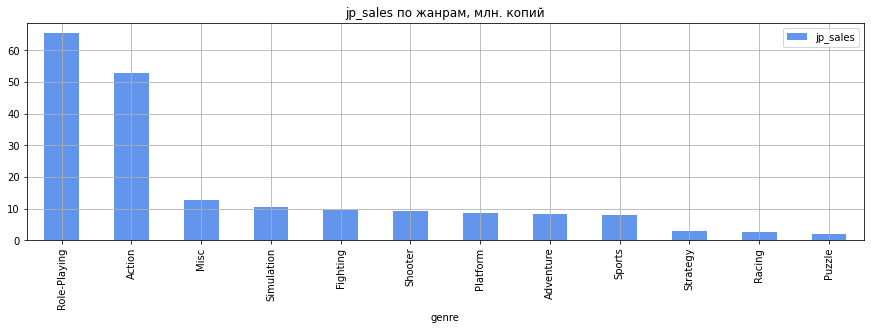

In [132]:
# jp_sales

games_act.pivot_table(
    index=['genre'], values='jp_sales', aggfunc='sum'
).sort_values(
    by='jp_sales', ascending=False
).plot(
    kind='bar',
    title="jp_sales по жанрам, млн. копий",
    figsize=(15,4),
    color='CornFlowerBlue',
    grid=True
);
plt.legend(loc='best');

А вот на Японском рынке все выглядит совсем иначе. 

Безусловные лидеры: Role-Playing (34%), Action (27,4%). И следцющие жанры отстают от Action почти в 4 раза. 

Puzzle и Strategy - аутсайдеры независимо от рынка.

### Влияние рейтинга ESRB на продажи в отдельном регионе.

In [136]:
# Распределение игр по rating na_sales

games_act.pivot_table(
    index='rating',
    values='na_sales',
    aggfunc=('sum')
).sort_values(
    by='na_sales', ascending=False
).plot(
    title='na_sales по rating',
    y='na_sales',
    # Распределение игр по rating jp_sales

games_act.pivot_table(
    index='rating',
    values='jp_sales',
    aggfunc=('sum')
).sort_values(
    by='jp_sales', ascending=False
).plot(
    title='jp_sales по rating',
    y='jp_sales',
    kind='bar',
    fontsize = 12,
    #autopct='%1.1f%%',
    figsize=(13,3),
    color='CornFlowerBlue',
    grid=True
)
plt.legend(loc='best');

    kind='bar',
    fontsize = 12,
    #autopct='%1.1f%%',
    figsize=(13,3),
    color='SkyBlue',
    grid=True
)
plt.legend(loc='best');

# Распределение игр по rating eu_sales

games_act.pivot_table(
    index='rating',
    values='eu_sales',
    aggfunc=('sum')
).sort_values(
    by='eu_sales', ascending=False
).plot(
    title='eu_sales по rating',
    y='eu_sales',
    kind='bar',
    fontsize = 12,
    #autopct='%1.1f%%',
    figsize=(13,3),
    color='SteelBlue',
    grid=True
)
plt.legend(loc='best');

# Распределение игр по rating jp_sales

games_act.pivot_table(
    index='rating',
    values='jp_sales',
    aggfunc=('sum')
).sort_values(
    by='jp_sales', ascending=False
).plot(
    title='jp_sales по rating',
    y='jp_sales',
    kind='bar',
    fontsize = 12,
    #autopct='%1.1f%%',
    figsize=(13,3),
    color='CornFlowerBlue',
    grid=True
)
plt.legend(loc='best');


#.query('rating != "Not Defined"')

SyntaxError: positional argument follows keyword argument (3755653379.py, line 30)

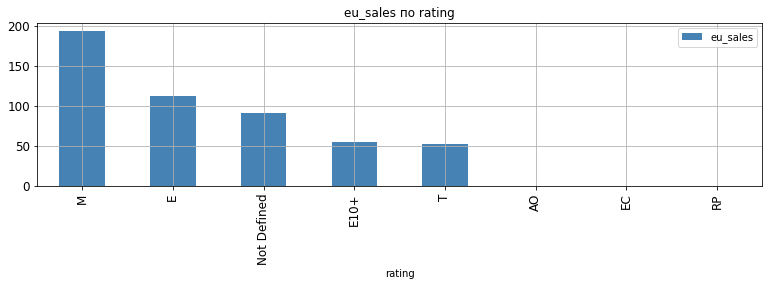

In [137]:
# Распределение игр по rating eu_sales

games_act.pivot_table(
    index='rating',
    values='eu_sales',
    aggfunc=('sum')
).sort_values(
    by='eu_sales', ascending=False
).plot(
    title='eu_sales по rating',
    y='eu_sales',
    kind='bar',
    fontsize = 12,
    #autopct='%1.1f%%',
    figsize=(13,3),
    color='SteelBlue',
    grid=True
);
plt.legend(loc='best');

#.query('rating != "Not Defined"')

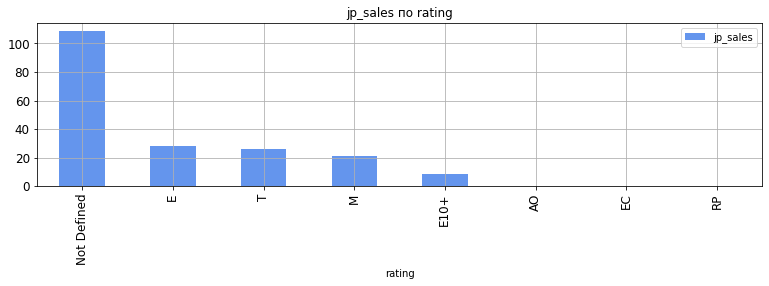

In [138]:
# Распределение игр по rating jp_sales

games_act.pivot_table(
    index='rating',
    values='jp_sales',
    aggfunc=('sum')
).sort_values(
    by='jp_sales', ascending=False
).plot(
    title='jp_sales по rating',
    y='jp_sales',
    kind='bar',
    fontsize = 12,
    #autopct='%1.1f%%',
    figsize=(13,3),
    color='CornFlowerBlue',
    grid=True
);
plt.legend(loc='best');

#.query('rating != "Not Defined"')

По параметру rating на первом месте в Северной Америке и Европе категория M (от 17 лет), которая почти в 2 раза превышает следующую категорию Е (для всех). Затем, постепенно снижаясь идут Not Defined (игры, для которых отсутствуют рейтинги), E10+ (от 10 лет) и T (от 13 лет).

в Японии на первом месте - Not Defined, который превышает следующую категорию почти в 4 раза. Далее примерно равные доли занимают Е, Т, М. На последнем - Е10+.

Возможно в Японии более популярны локальные игры, которые не распространены в Северной Америке и Европе и поэтому не имеют рейтинга ESRB. Поэтому мы наблюдаем именно такое распределение категорий и объемы продаж по ним.

## Шаг. Проверка гипотез.

При проверке гипотез у нас в обоих случаях есть две разные (независимые) выборки. Поэтому воспользуемся методом .scipy.stats.ttest_ind().

### Средние пользовательские рейтинги платформ Xbox One и PC.

Сформулируем нулевую (H0) и альтернативную (H1) гипотезы.

**Нулевая гипотеза:** 
Средний пользовательский рейтинг платформы Xbox One равен среднему пользовательскому рейтингу платформы PC.

**Альтернативная гипотеза:** 
Средний пользовательский рейтинг платформы Xbox One не равен среднему пользовательскому рейтингу платформы PC.

In [ ]:
# Создадим первую выборку для платформы Xbox One

g_xone = games_act.query('platform == "XOne" and user_score > 0')

In [ ]:
# Создадим вторую выборку для платформы PC

g_pc = games_act.query('platform == "PC" and user_score > 0')

In [ ]:
# Зададим уровень статистической значимости

alpha = 0.05

In [ ]:
#  В новую переменную сохраним данные о распределении вероятностей

results = st.ttest_ind(g_xone['user_score'],  g_pc['user_score'])

In [ ]:
# Выведем p-value

results.pvalue

In [ ]:
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу о том, что Средний пользовательский рейтинг платформы Xbox One равен среднему пользовательскому рейтингу платформы PC')
else:
    print('Не получилось отвергнуть нулевую гипотезу о том, что Средний пользовательский рейтинг платформы Xbox One равен среднему пользовательскому рейтингу платформы PC')

**Вывод:** Не получилось отвергнуть нулевую гипотезу, есть основания утверждать, что Средний пользовательский рейтинг платформы Xbox One равен среднему пользовательскому рейтингу платформы PC.

### Средние пользовательские рейтинги жанров Action и Sports .

Сформулируем нулевую (H0) и альтернативную (H1) гипотезы.

**Нулевая гипотеза:** 
Средний пользовательский рейтинг жанра Action равен среднему пользовательскому рейтингу жанра Sports.

**Альтернативная гипотеза:** 
Средний пользовательский рейтинг жанра Action не равен среднему пользовательскому рейтингу жанра Sports.

In [ ]:
# Создадим первую выборку для жанра Action

g_action = games_act.query('genre == "Action" and genre != "Not Defined" and user_score > 0')

In [ ]:
# Создадим вторую выборку для жанра Sports

g_sports = games_act.query('genre == "Sports" and genre != "Not Defined" and user_score > 0')

In [ ]:
# Зададим уровень статистической значимости

alpha = 0.05

In [ ]:
#  В новую переменную сохраним данные о распределении вероятностей

results = st.ttest_ind(g_action['user_score'],  g_sports['user_score'])

In [ ]:
# Выведем p-value

results.pvalue

In [ ]:
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу о том, что Средний пользовательский рейтинг жанра Action равен среднему пользовательскому рейтингу жанра Sports.')
else:
    print('Не получилось отвергнуть нулевую гипотезу о том, что Средний пользовательский рейтинг жанра Action равен среднему пользовательскому рейтингу жанра Sports.')

**Вывод:** Нулевая гипотеза отвергнута, есть основания утверждать, что Средний пользовательский рейтинг жанра Action не равен среднему пользовательскому рейтингу жанра Sports.

## Общий вывод.

Исходные данные корректны: нет явных дубликатов, искаженных значений. 

Большое количество пропусков в колонках с рейтингом, оценками пользователей и критиков обусловлено историческими факторами: развитие компьютеров, сети интеренет и компьютерно-игровой индустрии. 

Данные до 1994 года не типичны, и характеризуют самый ранний этап зарождения компьютерных игр. Нормальные данные появляются с 1994г. 

Количество и Продажи игр с этого времени растут относительно медленно до 2002г. С этого периода начинается стремительный рост индустрии (и всех рассматриваемых показателей), достигая пика в 2008-2009гг. Вероятно, это вызвано доступностью "домашних" компьютеров и развитием сети интернет. 

Далее показатели колчиества игр и продаж начинают довольно быстро снижаться до 2011 г, резко проседая в 2012г. Далее показатели снижаются, но уже относительно медленными темпами. Полагаю, это связано с развитием смартфонов и планшетов, что отвлекло значительную часть пользователей и ресурсов от копьютерных игр.

За весь преиод наблюдейний выделяются ТОП-6 игровых платформ с максимальными покзаателями продаж: PS2, X360, PS3, Wii, DS, PS. Максимальные продажи отмечаются с 1995 по  2010гг. Далее мы видим, что новые платформы появляются достаточно активно, но уровень продаж значительно ниже, что соответсвует общему снижению поазателей рынка компьютерных игр.

Средний срок жизни популярных платформ (ТОП-6) составляет от 8 до 10 лет. 
Если брать весь период наблюдейний, то медианный срок жизни платформ - 6 лет.

В 2015г можно выделить 3 платформы, потенциально не достигших совего пика: PS4, XOne, WiiU. И пока еще относительно продаваемые, но , похоже, прошедшие пик активности: PCV, 3DS. 

В качестве актуального периода, на мой взгляд, стоит выбрать период с 2012г., когда начался серьезный спад индустрии компьютерных игр. 

По Продажам (если брать нормлаьные значения без выбросов и аномальных значений) очевидный лидер - это PS4 (~ 1,7 млн. копий) и XOne ( ~ 1.6 млн.копий). Затем идут PS3 ( ~ 1.4 млн.копий) и WiiU (~ 1.25 млн.копий). Замыкает пятерку 3DS (~ 0.75 млн. копий).

Медианные значения продаж примерно равны у 4-с основных платформ: 0,2-0,22 млн. копий и почти в 2 раза ниже у 3DS.

25% всех продаж составляют от 0,05 (ЗPS3)-0,06 (PS4, XOne) до 0,8 (WiiU). Минимальное знаыение у 3DS - 0.04 млн. копий.

75% продаж составляют от 0,53 (WiiU) - 0,61 (PS3) до 0,69 (XOne) - 0,73 (PS4). Минимальное значение у 3DS - 0,31 млн.копий.

Отзывы критиков и пользователей имеют некоторое влияние на общий уровень продаж игр: чем выше отзывы, тем выше продажи. Отзывы критиков более значимы, чем отзывы пользователей. Однако эта зависимость не столь сильная, и, вероятно, не линейная. 

При этом есть отличия между играми, полулярными в Северной Америке и Европе и популярными в Японии. Если в первом случае коэффициент корреляции отзывов критиков составляют от 33% (PS3) до 41% (XOne), а отзывов пользователей от -0,6% (PS3) до -3% (PS4), то во втором отзывы критиков ~ 32% (3DS)- 34% (WiiU), а пользователей 19% (3DS)- 40% (WiiU).

По жанрам безусловным лидером Суммарных продаж является Action, затем Shooter, Role_Playing и Sports. 
Если рассматривать медианные показтели продаж, то на первом месте с отрывом почти в 2 раза нахдится жанр SHooter, далее Sports, чуть меньше Platform - они составляют почти 50% всех медианных продаж, и затем примерно на одном уровне Role_Playing и Racing. 

Наименее популярные жанры во все времена: Adventure, Puzzle, Strategy, их доля около 9% общего объема продаж.

Следует отметить, что на разных платформах распределение ТОП-5 популярных жанров разное. (более детально эта информация представлена на диаграммах в ислледовании).

Если рассматривать различные рынки, то можно отметить следующее.

По суммарным продажам самые популярные платформы в Северной Америке - X360 (около 140 млн. копий), в Европе - PS4 (140 млн.копий) и в Японии 3DS (87 млн.копий). 

ТОП-5 Платформ:
* в Северной Америке (X360, PS4, PS3, XOne, 3DS) составляют 84.7% общего объема продаж в регионе.
* в Европе (PS4, PS3, X360, XOne, 3DS) составляют 82.2% общего объема продаж в регионе.
* в Японии (3DS, PS3, PSV, PS4, WiiU) составляют 89.9% общего объема продаж в регионе, при этом на 3DS приходится 45.6% - очень большой отрыв от остальных платформ.

ПО полуярности жанров Северная Америка и Европа имеют схожие характеристики. Здесь лидируют: ACtion, Shooter, Sports, (доля в Европе незначительно ниже, чем в Северной Америке). При этом на них приходится 2/3 продаж. 
А вот в Японии безусловные лидеры: Role-Playing и Action - они занимают 61% продаж. Следующий по порядку жанр (Miscellanious) занимает долю в 4 раза меньшую

Всемирные аутсайдеры: Strategy и Puzzle.

Рейтинг ESRB имеет значение в Северной Америке и Европе. На первом месте хдесь игры с рейтингом М (от 17 лет) - их доля почти в 2 раза больше следующей группы. Далее идут игры с рейтингом Е (для всех) и игры, для которых рейтинг не определен или не указан. И далее примерно на одном уровне - Е10+ (от 10 лет) и Т (от 13 лет)
В Японии лидером продаж являются игры с неопределенным рейтингом. Почти на 2/3 превышая следующую группу. Вероятно, это локальные игры, не столь распространенные в Европе и Северной Америке и потому не имеющие этого рейтинга. Далее примерно на одном уровне идут игры с рейтингом Е, т, м и на последнем месте Е10+.

Для проверки гипотез был использован метод st.ttest_ind - дл ясравнения двух независимых выборок. 
В результате проверки гипотез есть основания утверждать, что:
* Средний пользовательский рейтинг платформы Xbox One равен среднему пользовательскому рейтингу платформы PC.
* Средний пользовательский рейтинг жанра Action не равен среднему пользовательскому рейтингу жанра Sports.